In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tikzplotlib
import os

run_id = 40

folder_path = f'../data/output/run_{run_id}/'
tex_path = folder_path + 'figures_and_tables/'
# Create directory tex_path if it does not exist
os

In [55]:
results_deviance = pd.read_csv(folder_path + 'results_deviance.csv', index_col=0)

# Create the latex table
dev_table = results_deviance.copy()
dev_table = dev_table * 100
dev_table.rename(index = {
    'intercept': 'Intercept',
    'glm': 'GLM',
    'local-glm-boost': 'LocalGLMBoost'
},inplace=True)
dev_table.rename(columns = {'train':'Training','test':'Test'},inplace=True)
dev_table.loc['LocalGLMNet'] = [23.728, 23.945]
dev_latex = dev_table.round(3).to_latex()
print(dev_latex)
with open(tex_path + 'real_data_kappa.tex', 'w') as file:
    file.write(dev_latex)

\begin{tabular}{lrr}
\toprule
{} &  Training &    Test \\
\midrule
Intercept     &    25.058 &  25.298 \\
GLM           &    24.023 &  24.070 \\
LocalGLMBoost &    23.537 &  23.616 \\
LocalGLMNet   &    23.728 &  23.945 \\
\bottomrule
\end{tabular}



NameError: name 'tex_path' is not defined

In [49]:
n_estimators = pd.read_csv(folder_path + 'n_estimators.csv', index_col=0)['n_estimators']
beta0 = pd.read_csv(folder_path + 'beta_estimates.csv', index_col=0)['beta0']

features = n_estimators.index
cont_features = ['VehPower', 'VehAge','Density', 'DrivAge', 'BonusMalus', 'Area']
cat_features = ['VehGas','VehBrand','Region']

In [54]:
latex_table = "\centering \n"
latex_table += "\\begin{tabular}{c|lllllllll} \n"
latex_table += "\\toprule \n"

feature_header = ["& \\rotatebox{45}{\\texttt{" + feature + "}}" for feature in cont_features + cat_features]
latex_table += ' '.join(feature_header) + " \\\\ \n"

kappa_row = '\\kappa_j & '
cont_features_kappa = ' & '.join([str(n_estimators.loc[feature]) for feature in cont_features])
kappa_row += cont_features_kappa
for cat_feature in cat_features:
    dummy_features = [feature for feature in features if feature.startswith(cat_feature)]
    min_kappa = n_estimators.loc[dummy_features].min()
    max_kappa = n_estimators.loc[dummy_features].max()
    kappa_range = f'({min_kappa}-{max_kappa})'
    kappa_row += ' & ' + kappa_range
kappa_row += '\\\\ \n'
latex_table += kappa_row

beta_row =  '\\beta_{j0} & '
cont_features_beta = ' & '.join([str(np.round(beta0.loc[feature],2)) for feature in cont_features])
beta_row += cont_features_beta
for cat_feature in cat_features:
    dummy_features = [feature for feature in features if feature.startswith(cat_feature)]
    min_beta = np.round(beta0.loc[dummy_features].min(),2)
    max_beta = np.round(beta0.loc[dummy_features].max(),2)
    beta_range = f'({min_beta}-{max_beta})'
    beta_row += ' & ' + beta_range
beta_row += '\\\\ \n'
latex_table += beta_row
latex_table += '\\bottomrule \n'
latex_table += '\\end{tabular}'

print(latex_table)

\centering 
\begin{tabular}{c|lllllllll} 
\toprule 
& \rotatebox{45}{\texttt{VehPower}} & \rotatebox{45}{\texttt{VehAge}} & \rotatebox{45}{\texttt{Density}} & \rotatebox{45}{\texttt{DrivAge}} & \rotatebox{45}{\texttt{BonusMalus}} & \rotatebox{45}{\texttt{Area}} & \rotatebox{45}{\texttt{VehGas}} & \rotatebox{45}{\texttt{VehBrand}} & \rotatebox{45}{\texttt{Region}} \\ 
\kappa_j & 236 & 79 & 34 & 275 & 75 & 175 & (144-144) & (1-116) & (0-112)\\ 
\beta_{j0} & 0.46 & -1.71 & -0.04 & 0.58 & 6.04 & 0.48 & (-0.17--0.17) & (-0.67--0.21) & (-0.48-0.12)\\ 
\bottomrule 
\end{tabular}


<Figure size 1200x500 with 0 Axes>

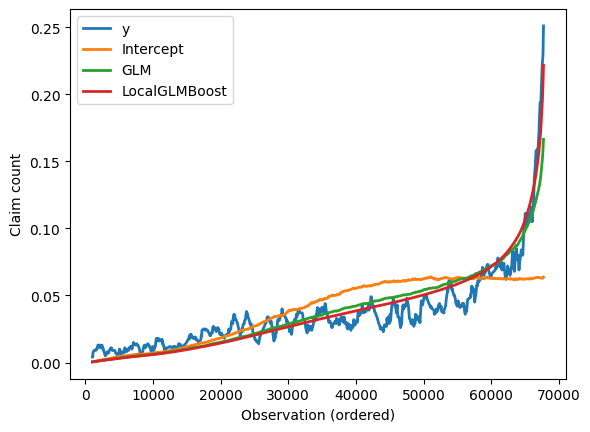

In [8]:
predictions = pd.read_csv(folder_path + 'predictions.csv', index_col=0)
mu_hat = predictions[['intercept','glm','local-glm-boost']].mul(predictions['w'],axis=0)
mu_hat['y'] = predictions['y']

n = len(mu_hat)
window_size = 1000 # n//100
prediction_results = mu_hat.sort_values('local-glm-boost').reset_index(drop=True).rolling(window_size).mean()[['y','intercept','glm','local-glm-boost']].dropna()
# Sample the data
sampled_predictions = prediction_results.sample(1000)
sampled_predictions.sort_values('local-glm-boost', inplace=True)

plt.figure(figsize=(12,5))
# Replace the column names with the names of the models
sampled_predictions.columns = ['y','Intercept','GLM','LocalGLMBoost']
# Plot the data with thicker lines
sampled_predictions.plot(linewidth=2);
# Add x-axis label "Observation (ordered)"
plt.xlabel('Observation (ordered)');
# Change the y-axis label to "Claim count (rolling average)"
plt.ylabel('Claim count');
# Save as tikz
tikzplotlib.save(folder_path + 'real_data_predictions.tex')

In [9]:
feature_importances_og = pd.read_csv(folder_path + 'feature_importances.csv', index_col=0)
feature_importances = feature_importances_og.copy().dropna()

reg_columns = [feature for feature in feature_importances.columns if feature.startswith('Region')]
feature_importances['Region'] = feature_importances[reg_columns].sum(axis=1)
feature_importances.drop(reg_columns, axis=1, inplace=True)
reg_index = [feature for feature in feature_importances.index if feature.startswith('Region')]
feature_importances.loc['Region'] = feature_importances.loc[reg_index].mean(axis=0)
feature_importances.drop(reg_index, axis=0, inplace=True)

veh_columns = [feature for feature in feature_importances.columns if feature.startswith('VehBrand')]
feature_importances['VehBrand'] = feature_importances[veh_columns].sum(axis=1)
feature_importances.drop(veh_columns, axis=1, inplace=True)
veh_index = [feature for feature in feature_importances.index if feature.startswith('VehBrand')]
feature_importances.loc['VehBrand'] = feature_importances.loc[veh_index].mean(axis=0)
feature_importances.drop(veh_index, axis=0, inplace=True)

feature_importances.round(2)

,VehPower,VehAge,DrivAge,BonusMalus,Density,Area,VehGas,Region,VehBrand
VehPower,605.16,1267365.86,1572231.77,5863940.00,0.00,0.0,0.0,0.14,147222.65
VehAge,0.00,456263.18,138973.98,475868.70,0.00,0.0,0.0,0.00,0.00
DrivAge,711090.58,0.00,4043295.59,8278158.78,114964.75,0.0,0.0,0.00,323675.39
BonusMalus,0.00,0.06,144855.91,63251.33,1.21,0.0,0.0,0.00,0.00
Density,0.00,0.00,0.00,770584.10,62632.60,0.0,0.0,0.00,0.00
Area,0.00,2013894.33,1603026.65,2150814.66,0.00,0.0,0.0,0.00,0.46
VehGas,44.45,493169.46,2029805.46,1906477.21,0.00,0.0,0.0,309.86,0.23
Region,8471.24,706.83,76689.21,772647.19,64880.71,0.0,0.0,160230.93,0.00
VehBrand,35799.78,235938.28,271434.94,748070.06,3734.52,0.0,0.0,1337.94,227170.37


In [10]:
veh_values = feature_importances.loc['VehBrand'].round(2).values

for i, value in enumerate(veh_values):
    string = f'{i} 8 {value}'
    print(string)

0 8 35799.78
1 8 235938.28
2 8 271434.94
3 8 748070.06
4 8 3734.52
5 8 0.0
6 8 0.0
7 8 1337.94
8 8 227170.37
